<a href="https://colab.research.google.com/github/franz6ko/vision-artificial-2/blob/master/Clase-3/Transfer_Learning_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

--2021-08-06 18:58:27--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   194MB/s    in 0.3s    

2021-08-06 18:58:28 (194 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -q cats_and_dogs_filtered.zip

In [3]:
train_dir = "cats_and_dogs_filtered/train"
validation_dir = "cats_and_dogs_filtered/validation"

## Primero como siempre importamos los datos

In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Ahora importamos la red y los pesos de la red VGG16

In [71]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [72]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Setear los parámetros del modelo base a no entrenable

In [73]:
vgg_base.trainable=False 

### Ahora hay que agregar las últimas capas de la red:

In [74]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(vgg_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Entrenamos el modelo

In [75]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [76]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 38s 330ms/step - loss: 0.5523 - acc: 0.7285 - val_loss: 0.3757 - val_acc: 0.8470
Epoch 2/3
100/100 [==============================] - 32s 324ms/step - loss: 0.4238 - acc: 0.7985 - val_loss: 0.3187 - val_acc: 0.8710
Epoch 3/3
100/100 [==============================] - 32s 324ms/step - loss: 0.3685 - acc: 0.8420 - val_loss: 0.2507 - val_acc: 0.9110


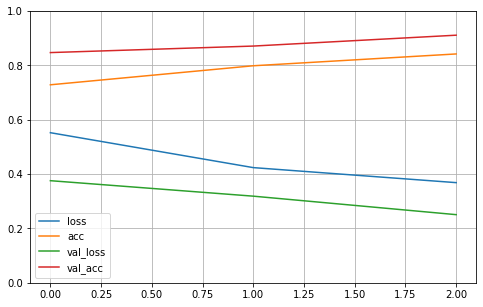

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Hacer lo mismo con ResNet50:

In [ ]:
from tensorflow.keras.applications import ResNet50

base_resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

base_resnet.trainable=False 
base_resnet.summary()

### Agregar las últimas capas de la red:

In [114]:
model2 = models.Sequential()
model2.add(base_resnet)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_27 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_67 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 257       
Total params: 49,278,337
Trainable params: 25,690,625
Non-trainable params: 23,587,712
_________________________________________________________________


### Entrenamos el modelo

In [115]:
model2.compile(loss='binary_crossentropy', optimizer=optimizers.Adamax(learning_rate=1e-5), metrics=['acc'])

history2 = model2.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 36s 331ms/step - loss: 0.7131 - acc: 0.5305 - val_loss: 0.6726 - val_acc: 0.5850
Epoch 2/10
100/100 [==============================] - 32s 318ms/step - loss: 0.6745 - acc: 0.5760 - val_loss: 0.6590 - val_acc: 0.6040
Epoch 3/10
100/100 [==============================] - 31s 306ms/step - loss: 0.6752 - acc: 0.5840 - val_loss: 0.6598 - val_acc: 0.6120
Epoch 4/10
100/100 [==============================] - 32s 322ms/step - loss: 0.6685 - acc: 0.5935 - val_loss: 0.6560 - val_acc: 0.6160
Epoch 5/10
100/100 [==============================] - 31s 305ms/step - loss: 0.6668 - acc: 0.5985 - val_loss: 0.6608 - val_acc: 0.5900
Epoch 6/10
100/100 [==============================] - 32s 320ms/step - loss: 0.6868 - acc: 0.5715 - val_loss: 0.6487 - val_acc: 0.6220
Epoch 7/10
100/100 [==============================] - 30s 304ms/step - loss: 0.6598 - acc: 0.6125 - val_loss: 0.6550 - val_acc: 0.6180
Epoch 8/10
100/100 [==============================] - 3

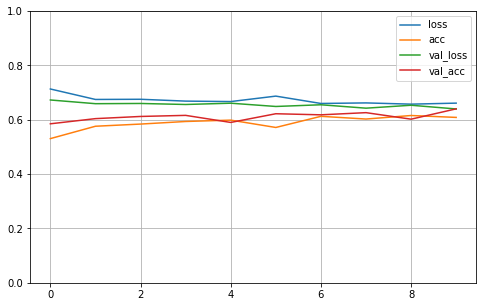

In [116]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()